In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import sys
import json
import os
import sys
import itertools
import numpy as np
from utils import create_result_list, filter_div, plot, \
                 combine_metrics, plot_results_metrics, get_results_stats

path_to_exp = os.getcwd() + "/runs"

In [2]:
exclude_folders = ['/deleted', '/.ipynb_checkpoints', '/divergent']
exclude = [path_to_exp + folder for folder in exclude_folders]
all_exps = [f.path for f in os.scandir(path_to_exp) if f.is_dir() and f.path not in exclude]
print("{} runs.".format(len(all_exps)))

41 runs.


In [3]:
scores = [pickle.load(open(path + "/score_list.pkl", "rb")) 
         for path in all_exps if os.path.isfile(path + "/score_list.pkl")]
dicts = [json.load(open(path + "/exp_dict.json"))
            for path in all_exps if os.path.isfile(path + "/score_list.pkl")]
ids = [x[-5:] for x in all_exps]

* ``scores`` is a list containting $n_{exp}$ lists. Each list contains $n_{epochs}$ dictionaries. Each dictionary contains as keys the metrics we are monitoring, and as values the actual values of these metrics.
* ``dicts`` is a list containing $n_{exp}$ dictionaries. Each dictionary contains as keys the hyperparameters and model/dataset information, and as values the corresponding hyperparameters and model/dataset choices.

## Filter models according to chosen criteria

In [4]:
div_criteria_keys = list(scores[0][0].keys())
div_criteria_keys

['epoch',
 'train_loss',
 'train_grad',
 'adv_grad',
 'adv_train_loss',
 'quad_loss',
 'val_score',
 'grad_phi',
 'phi',
 'eff_train_time',
 'epoch_train_time',
 'total_time']

With `div_criteria = {'epoch' : (-1, 198), 'val_score': (-1, 0.9), 'grad_phi': (1, 1e-2)}`, we only keep the runs which were run for 200 epochs and where we had a `val_score` larger. i.e. we ignore the runs where the validation accuracy was too low to be meaningful.

In [5]:
div_criteria = {'epoch': (-1, 198), 'val_score': (-1, 0.8)}

In [6]:
scores, dicts, keep = filter_div(scores, dicts, div_criteria)

# Choosing hyperparameters to display

In [7]:
hyperparam_choices = ['lr_d', 'lr_a', 'loop_size', 'p', 'runs']

In [8]:
all_chosen_hyper = []
for dic in dicts:
    new_dic = {}
    for hyper in hyperparam_choices:
        for hyper in hyperparam_choices:
            if hyper not in dic.keys():
                continue
            else:
                new_dic[hyper] = dic[hyper]
    all_chosen_hyper.append(new_dic)

In [9]:
all_possible_hyper = {}
for hyperparam_name in hyperparam_choices:
    all_possible_hyper[hyperparam_name] = []
    for i in range(len(dicts)):
        if hyperparam_name not in dicts[i].keys():
            continue 
        if dicts[i][hyperparam_name] not in all_possible_hyper[hyperparam_name]:
            all_possible_hyper[hyperparam_name].append(dicts[i][hyperparam_name])

# Displaying all the plots

With `filterby = {'lr_d': [0.1, 0.5, 0.3, 0.075, 0.2], 'lr_a':[0.1, 0.5, 1, 10, 100, 5]}`, we only consider the experiments which have parameters `(lr_a, lr_d)` in the cartesian products of the two sets.

In [10]:
filterby = {}
metrics_x = ['epoch', 'eff_train_time']
metrics_y = ['grad_phi', 'val_score', 'adv_grad', "phi"]
metrics = metrics_x + metrics_y

In [11]:
results = create_result_list(dicts, scores, filterby, metrics)
for i in range(len(results)):
    for key, value_list in results[i][1].items():
        results[i][1][key] = np.array(value_list)

We're going to plot on each line the results for one specific ``metric_x``, along the columns the results for one specific ``metric_y``.

In [12]:
display_params = hyperparam_choices

In [13]:
print('The number of experiments after filtering is {}. Out of {}.'.format(len(results), len(all_exps)))

The number of experiments after filtering is 38. Out of 41.


In [14]:
ylims = [(1e-7, None), (0.8, 1), (1e-8, 1e-1), (1.3, 1.466)]
plot_types = ['skip', 'regular', 'semilog', 'skip']

skip_steps = 20 # depending on the number of steps before computing grad(phi)(x)
skip = [skip_steps, None, None, skip_steps]

In [15]:
assert len(ylims) == len(plot_types)
assert len(ylims) == len(metrics_y)

/Users/othmanesebbouh/Desktop/phd/current_projects/learning_sinkhorn/exp1/utils.py:106: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


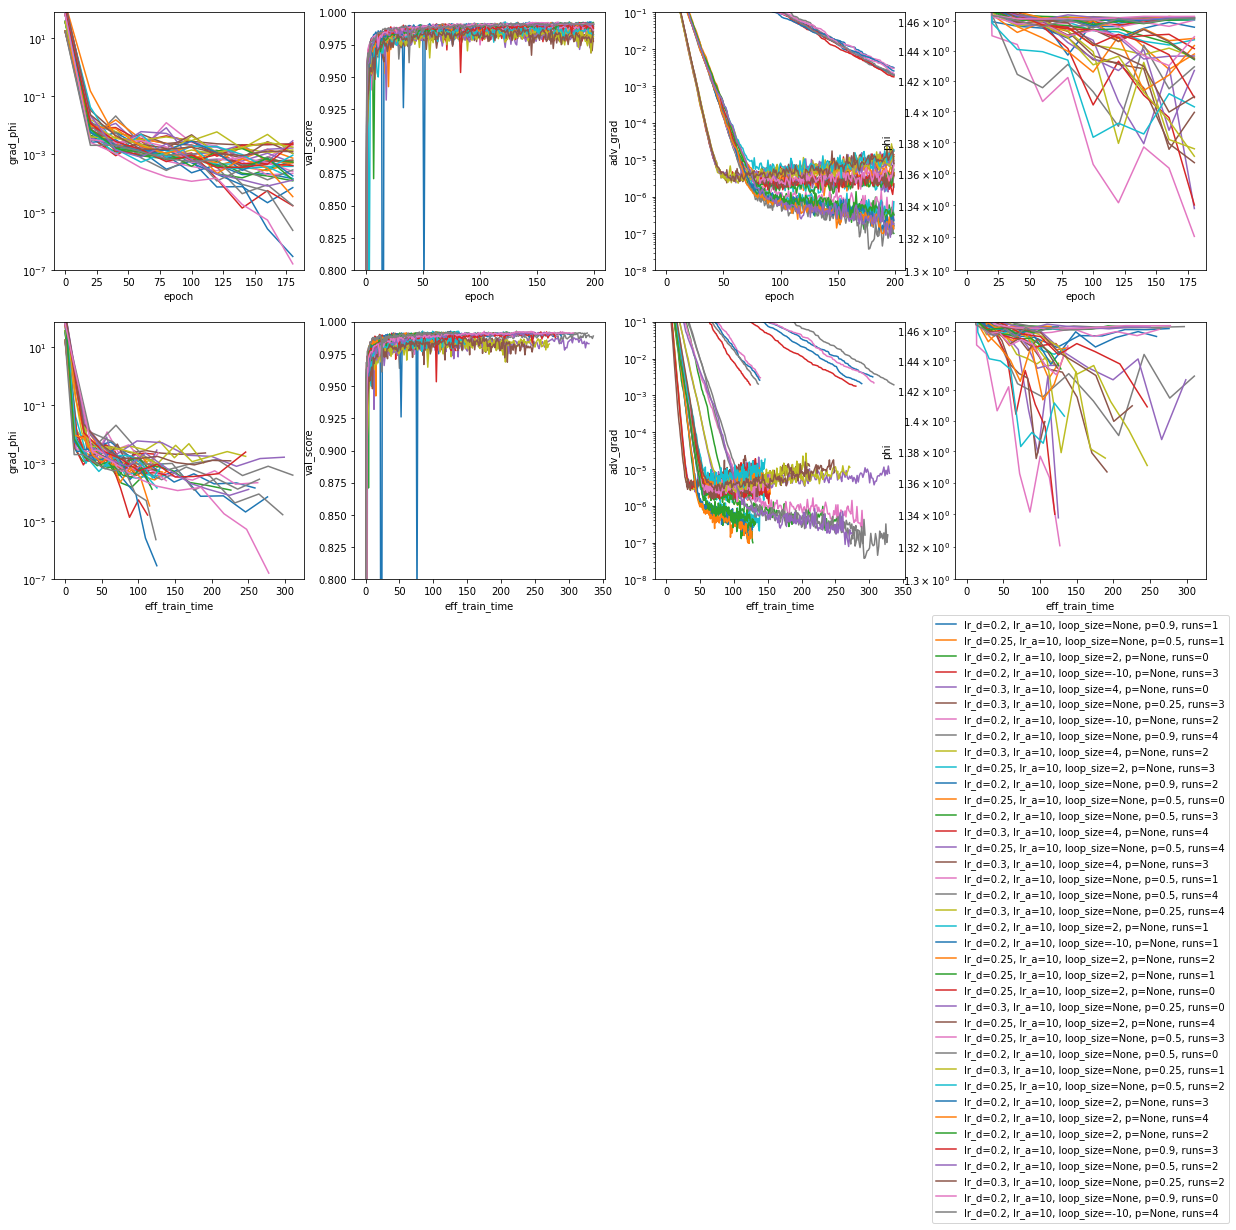

In [16]:
plot_results_metrics(results, metrics_x, metrics_y, ylims, display_params, plot_types, skip)

# Reproducing Fig. 1 of the paper

In [17]:
metric = "phi"

In [18]:
specific_parameters = [(0.2, 10, None, p) for p in [0.25, 0.5, 0.9]] + \
                      [(0.25, 10, None, 0.5)] + \
                      [(0.3, 10, None, p) for p in [0.1,0.25]]

specific_parameters = [(0.3, 10, None, 0.25), (0.3, 10, 4,   None)] + \
                      [(0.2, 10, None, 0.5),  (0.2, 10, 2,   None)] + \
                      [(0.25, 10, None, 0.5),  (0.25, 10, 2, None)]

specific_results = []
for i, (result, _) in enumerate(results):
    if 'p' not in result.keys():
        result['p'] = None
    if (result['lr_d'], result['lr_a'], result['loop_size'], result['p']) in specific_parameters:
        specific_results.append(results[i])

In [19]:
# ordering hyperparameters for plot
order_hyperparams = [(0.2, 0.25), 
                     (0.2, 0.5), 
                     (0.2, 0.9), 
                     (0.25, 0.5), 
                     (0.3, 0.1), 
                     (0.3, 0.25)]

order_hyperparams = [(0.5, None, 0.2), (None, 2, 0.2), 
                     (0.5, None, 0.25), (None, 2, 0.25),
                     (0.25, None, 0.3), (None, 4, 0.3)]


custom_legend = [r'$\alpha=0.2  \; \; p=0.25$',
                 r'$\alpha=0.2 \; \; p=0.5$',
                 r'$\alpha=0.2  \; \; p=0.9$',
                 r'$\alpha=0.25  \: \,  p=0.5$',
                 r'$\alpha=0.3   \; \;p=0.1$',
                 r'$\alpha=0.3   \; \;p=0.25$',
                ]

custom_legend = [r'$\alpha=0.2 \; \; \, p=0.5$',
                 r'$\alpha=0.2 \; \; \, m=1$',
                 r'$\alpha=0.25 \; \; p=0.5$',
                 r'$\alpha=0.25 \;  \; m=1$',
                 r'$\alpha=0.3 \; \: \; \;  p=0.25$',
                 r'$\alpha=0.3 \; \: \;  m=3$',
                ]

/Users/othmanesebbouh/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
<ipython-input-20-c8def7ad620b>:25: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.savefig("../figures/fig1.pdf", bbox_inches='tight', pad_inches=0.0)
<ipython-input-20-c8def7ad620b>:25: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.savefig("../figures/fig1.pdf", bbox_inches='tight', pad_inches=0.0)
<ipython-input-20-c8def7ad620b>:25: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.savefig("../figures/fig1.pdf", bbox_inches='tight', pad_inches=0.0)
<ipython-

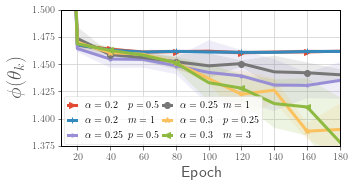

In [20]:
plt.style.use('ggplot')

rc = {"pdf.fonttype": 42, 'text.usetex': True, 'text.latex.preview': True, 
      "axes.facecolor": 'w', "grid.color": 'D3D3D3'}
plt.rcParams.update(rc)

marker = itertools.cycle(('>', '+', '.', 'o', '*', '<')) 

fig, ax = plt.subplots(figsize=(5, 2.5))

stacked_results_ordered = get_results_stats(results, metric, specific_parameters, all_chosen_hyper,
             specific_results, order_hyperparams, skip_steps)
for hyperparams, stats in stacked_results_ordered:
    mean, std, max_score, min_score = stats
    x = np.linspace(0, 180, len(mean))
    plt.plot(x, mean, linewidth=3, marker=next(marker), markevery=2)
    ax.fill_between(x, mean + std, mean - std, alpha = 0.15)

ax.set_xlim([10, 180])
ax.set_ylim([1.375, 1.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel(r'$\phi(\theta_k)$', fontsize=20)
ax.legend(custom_legend, ncol=2, columnspacing=0.5, handlelength=0.8, fontsize=10, loc=(0.01, 0.01))
plt.setp(ax.spines.values(), linewidth=1, color='black')
plt.savefig("../figures/fig1.pdf", bbox_inches='tight', pad_inches=0.0)